In [1]:
%matplotlib notebook
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize

# Weight and Balance

## Fuel
Define fuel loaded at start of flight.  1.4 gallons is typically assumed for consumption during taxi and run-up.  

In [2]:
fuel_start = (40 - 1.4) * u.gal
density_100LL = 6 * u.imperial.lb / u.gal
weight_fuel_start = fuel_start * density_100LL

## Manifest
Passengers row 1 and 2, left and right seats.  Baggage areas 1 and 2.

In [3]:
weight_1_L = 155 * u.imperial.lb
weight_1_R = 155 * u.imperial.lb
weight_2_L = 254 * u.imperial.lb
weight_2_R = 0 * u.imperial.lb
weight_bag_1 = 50 * u.imperial.lb
weight_bag_2 = 0 * u.imperial.lb

## Aircraft Empty Weight
This is a generic number for a Cessna 172N.  Numbers for the actual aircraft being flow shoud be used.

In [4]:
weight_empty = 1454 * u.imperial.lb
arm_empty = 39.6 * u.imperial.inch

## Moment Arms
Average values from a Cessna 172N POH.

In [5]:
arm_fuel = 47.9 * u.imperial.inch
arm_1 = 37 * u.imperial.inch
arm_2 = 73 * u.imperial.inch
arm_bag_1 = 95 * u.imperial.inch
arm_bag_2 = 123 * u.imperial.inch

## Weight and Balance for Start of Flight

In [6]:
weight_start = (weight_empty + weight_fuel_start +
                weight_1_L + weight_1_R +
                weight_2_L + weight_2_R +
                weight_bag_1 + weight_bag_2)
weight_start

<Quantity 2299.6 lb>

In [7]:
mom_start = (weight_empty * arm_empty +
             (weight_fuel_start) * arm_fuel +
             (weight_1_L + weight_1_R) * arm_1 +
             (weight_2_L + weight_2_R) * arm_2 +
             (weight_bag_1) * arm_bag_1 +
             (weight_bag_2) * arm_bag_2)
cg_start = mom_start / weight_start
cg_start

<Quantity 44.979144198991136 inch>

## Operating Envelopes
Digitized data from a Cessna 172N POH

In [8]:
CG_Normal = np.array([[35,1500],
                    [35, 1950],
                    [38.5,2300],
                    [47.25,2300],
                    [47.25,1500]])
CG_Utility = np.array([[35,1500],
                      [35,1950],
                      [35.5,2000],
                     [40.5,2000],
                     [40.5,1500]])

<IPython.core.display.Javascript object>


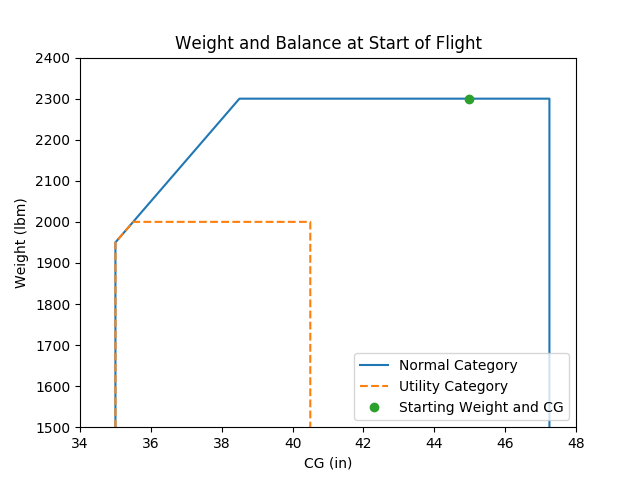

In [9]:
Env_Normal = plt.plot(CG_Normal[:,0], CG_Normal[:,1], '-C0', label="Normal Category")
Env_Utility = plt.plot(CG_Utility[:,0], CG_Utility[:,1], '--C1', label="Utility Category")
WB_Start = plt.plot(cg_start, weight_start, 'oC2', label="Starting Weight and CG")

plt.xlabel("CG (in)")
plt.ylabel("Weight (lbm)")
plt.title("Weight and Balance at Start of Flight")
plt.axis([34,48,1500,2400])
plt.legend(loc='best')

# Cruise Performance

## Standard Atmosphere Interpolator

In [10]:
atmosphere = pd.read_excel('atmosphere.xlsx')
atmosphere = atmosphere.set_index('alt')
#atmosphere.tail()

In [11]:
def atm_interp(altitude):
    # input is altitude in meters
    # output is an array returning: 0 density ratio [-], 1 pressure ratio [-], 2 temperature ratio [-], 
    # 3 temperature [K], 4 pressure [Pa], 5 density [kg/m^3], 
    # 6 speed of sound [m/s], 7 dynamic viscosity [Pa s], 8 and kinematic viscosity [m^2/s]
    if altitude in atmosphere.index:
        return atmosphere.ix[altitude].as_matrix()
    else:
        blank_alt = pd.Series([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan], 
                              index=['sigma', 'delta', 'theta', 'temp', 'press', 'dens', 'a', 'visc', 'k.visc'],
                              name=altitude)
        new_atmosphere = atmosphere.append(blank_alt).sort_index().interpolate(method='index')
        return new_atmosphere.ix[altitude].as_matrix()
    

In [12]:
atm_interp(5560)[5]

0.69255999999999995

## TAS Calculation
from altitude and engine power setting
TODO: add temperature correction

In [13]:
cruise_alt = 5500 * u.imperial.ft
power_setting = 0.75 * 160 * u.imperial.hp

In [14]:
function_cl = power_setting / (np.power(weight_start * 9.81 * u.m / u.s**2,1.5) 
               * np.sqrt(2 / (atm_interp(cruise_alt.to(u.m).value)[5] * u.kg / u.m**3 * 174 * u.imperial.ft**2)))

In [15]:
function_cl = function_cl.decompose()

In [16]:
def solve_function(cl):
    return (0.0404 - 0.0093*cl + 0.0794 * cl**2) / (cl**1.5) - function_cl

In [17]:
cl_solution = optimize.fsolve(solve_function, 0.4)[0]

In [18]:
TAS = np.sqrt(2 * weight_start * 9.81 * u.m / u.s**2 / (atm_interp(cruise_alt.to(u.m).value)[5] * u.kg / u.m**3
                                                        * 174 * u.imperial.ft**2 * cl_solution))

In [19]:
TAS.to(u.imperial.kn)

<Quantity 119.69137742830429 kn>